In [1]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import tqdm.auto as tqdm
from PIL import Image, ImageOps
rng = jax.random.PRNGKey(2)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)

IMNN version:  0.3dev


In [5]:
N = 32

In [7]:
# def scipy_compute_r2(N):
#     _Di = np.tile(toeplitz(np.arange(N)), (N, N))
#     _Dj = np.concatenate(
#         [np.concatenate(
#             [np.tile(np.abs(i - j),(N, N)) 
#              for i in range(N)], 
#             axis=0)
#          for j in range(N)],
#         axis=1)
#     _distance_squared = _Di * _Di + _Dj * _Dj
#     return _distance_squared

# def compute_r2(N):
#     _r2 = np.tile(np.abs(np.expand_dims(np.arange(N), 0) 
#                     - np.expand_dims(np.arange(N), 1)), (N, N)) ** 2. + np.abs(np.expand_dims(np.repeat(np.arange(N), N), 0) 
#                              - np.expand_dims(np.repeat(np.arange(N), N), 1)) ** 2.
#     return _r2

# r2 = compute_r2(N).astype(np.float64)

# def ξ_G(β):
#     return np.exp(
#         -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
#         / 4. / np.expand_dims(β, (-2, -1))**2.)

# def get_G_field(β):
#     pass

# def fill_zeros(k, value):
#     from functools import partial

#     def fnk(k):
#         return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: value, lambda k: k+value, operand=k)

#     if len(k.shape) == 1:
#         return jax.vmap(fnk)(k)
#     else:
#         return jax.vmap(partial(fill_zeros, value=value))(k)


# def xi_LN(r, α, β, PixelNoise=0.01):

#     xi = 1/(np.power(α+1e-12,2)) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)

#     # Add pixel noise at zero separation:

#     xi = fill_zeros(xi, PixelNoise**2)
#     #xi[np.where(r<1e-5)] += PixelNoise**2

#     return xi

In [16]:
r2 = np.tile(
    np.abs(
        np.expand_dims(np.arange(N, dtype=np.float64), 0) 
        - np.expand_dims(np.arange(N, dtype=np.float64), 1)), 
    (N, N)) ** np.float64(2.) + \
    np.abs(
        np.expand_dims(np.repeat(np.arange(N, dtype=np.float64), N), 0)
        - np.expand_dims(np.repeat(np.arange(N, dtype=np.float64), N), 1)) ** np.float64(2.)
def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β**2., (-2, -1)))

In [17]:
# derivatives of corr function

In [18]:
def dxi_LN_dalpha(r, α, β):

    _deriv =  2/(α+1e-12) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 2/np.power(α+1e-12,3) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)
    return _deriv

def dxi_LN_dbeta(r, β, α):

    return (-0.5*r/np.power(β,2)) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2)))

In [19]:
def simulator(rng, n, 
        α, β, μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    dist = tfd.TransformedDistribution(
        #distribution=tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalTriL(
                loc=μ, 
                scale_tril=tfp.math.fill_triangular(σ) 
                    * np.linalg.cholesky(ξ_G(β))),
            #bijector=tfb.Reshape((N, N))),
        bijector=tfb.Chain([
            tfb.Scale(np.expand_dims(α, (-1))),
            tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
            tfb.Exp(),
            tfb.Shift(-np.float64(1.)),
            tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1)))]
            ))
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

In [21]:
def _f_NL(
        _α, _β, 
        μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
            β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(_β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.float64(1.) / np.expand_dims(_α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float64(0.5) * np.expand_dims(_α, -1)**np.float64(2.), scale=np.expand_dims(_α, -1))]))))

In [22]:
f_NL = tfd.JointDistributionNamed(
    dict(
        α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
        β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
        μ = tfd.Normal(
            loc=np.zeros((N**2,), dtype=np.float64), 
            scale=np.ones((N**2,), dtype=np.float64)),                 
        σ = tfp.distributions.Uniform(
            low=np.zeros((N**2 * (N**2 + 1) // 2,), dtype=np.float64), 
            high=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)),
        f_NL = lambda α, β, μ, σ: tfd.TransformedDistribution(
            #distribution=tfd.TransformedDistribution(
                distribution=tfd.MultivariateNormalTriL(
                    loc=μ, 
                    scale_tril=tfp.math.fill_triangular(σ) 
                        * np.linalg.cholesky(ξ_G(β))),
                #bijector=tfb.Reshape((N, N))),
            bijector=tfb.Chain([
                tfb.Scale(np.expand_dims(α, (-1))),
                tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
                tfb.Exp(),
                tfb.Shift(-np.float64(1.)),
                tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1)))]
                ))))

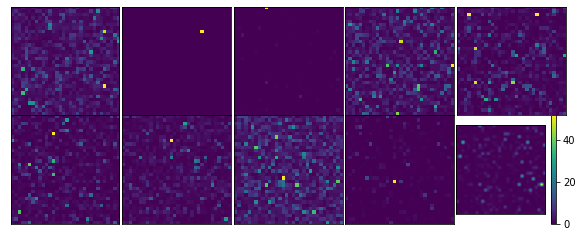

In [23]:
rng, key = jax.random.split(rng)
f_NLs = f_NL.sample(10, seed=key)["f_NL"].reshape((10, N, N))
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(5):
        a = ax[i, j].imshow(f_NLs[j + i * 5])
        ax[i, j].set(xticks=[], yticks=[])
plt.colorbar(a)

In [24]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))
target["f_NL"] = simulator(key, None, target["α"], target["β"])

In [25]:
size = 250
marginal = np.ones((size, size)) * np.nan
bar = tqdm.tqdm(np.linspace(0., 2., size))
for a, _α in enumerate(bar):
    if a != 0 and _α < 1.1:
        marginal = jax.ops.index_update(
            marginal, 
            jax.ops.index[a], 
            _f_NL(np.repeat(_α, size), np.linspace(0.2, 0.8, size)).prob(target))
        bar.set_postfix(a=a, α=_α)

  0%|          | 0/250 [00:00<?, ?it/s]

RuntimeError: Resource exhausted: Out of memory while trying to allocate 2097152000 bytes.

# set up IMNN for problem

In [77]:
# need: vmapped simulator (take from florent), model, training loop 
# get theoretical fisher using dξ/dα, dξ/dβ and the fisher function (built in fn for getting derivs w/proper r in florent's code)
# then: re-define tfp sampler model to use trained IMNN as compressor w/summaries as outputs
# sample
# compare to the full-field inference that uses all pixels as target values (RandomWalkSampler.ipynb)

In [14]:
input_shape = (1,1, N,N)
θ_fid = np.array([1.0, 0.5], dtype=np.float64)
# IMNN params
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

n_params = 2
n_summaries = 2

### compute known Fisher at fiducial 

In [85]:
r.shape

(1024, 1024)

In [78]:
α,β = θ_fid
ξ_LN    = xi_LN(r, α, β, PixelNoise=1.0) 
dξ_dα   = dxi_LN_dalpha(r, α, β)
dξ_dβ   = dxi_LN_dbeta(r, α, β)

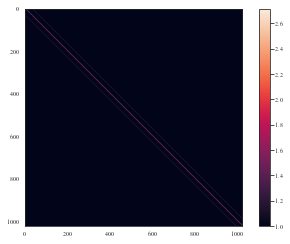

In [119]:
%matplotlib inline
plt.imshow(ξ_LN)
plt.colorbar()

In [122]:
np.diag(ξ_LN).shape

(1024,)

In [123]:
Nsq = N**2
r = np.sqrt(r2)#[:Nsq//2, :Nsq//2]


def known_fisher(r, θ):
    α,β = θ
    
    # extract diagonal from matrix
    ξ_LN    = np.diag(xi_LN(r, α, β, PixelNoise=0.1))
    # get derivatives
    dξ_dα   = dxi_LN_dalpha(r, α, β)
    dξ_dβ   = dxi_LN_dbeta(r, α, β)
    

    # reassign to a diagnonal matrix with zeros on off-diag
    Cinv = np.diag(1. / ξ_LN)          
    Ca =  (dξ_dα)           # C_{,A}
    Cb =  (dξ_dβ)           # C_{,B}
    
    # fisher matrix entries
    Faa = 0.5 * np.trace((Ca @ Cinv @ Ca @ Cinv))
    Fab = 0.5 * np.trace((Ca @ Cinv @ Cb @ Cinv))
    Fba = 0.5 * np.trace((Cb @ Cinv @ Ca @ Cinv))
    Fbb = 0.5 * np.trace((Cb @ Cinv @ Cb @ Cinv))

    return np.array([[Faa, Fab], [Fba, Fbb]])

In [124]:
f = known_fisher(r, θ_fid)
print(f)

detf_expected = np.linalg.det(f)
print(detf_expected)

[[705.9223   -61.09842 ]
 [-61.098427 630.36926 ]]
441258.84


### simulator for IMNN

In [159]:
simulator_args = {'N': 32, 'squeeze': False}
def imnn_simulator(rng, θ, simulator_args=simulator_args):
    A,B = θ
    N = simulator_args['N']
    #noise = 0.01
    def fn(key, A,B):
        if simulator_args['squeeze']:
            #target["f_NL"] = simulator(key, None, target["α"], target["β"])
            return np.expand_dims(simulator(key, None, A, B).reshape(N,N), 0)

        else:
            return (np.expand_dims(np.expand_dims(simulator(key, None, A, B).reshape(N,N), 0), 0))

    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: imnn_simulator(key, (A,B), simulator_args=simulator_args) #.reshape(N,N)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: imnn_simulator(key, (A, B), simulator_args=simulator_args) #.reshape(N,N)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: imnn_simulator(key, (A, B), simulator_args=simulator_args) #.reshape(N,N)
            )(keys, B)
    

In [16]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(imnn_simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [17]:
# define stax model
def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME"))

    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

In [18]:
fs = 32
model = stax.serial(
        #InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        #InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten
)

In [19]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

In [20]:
optimiser = optimizers.adam(step_size=1e-3)

In [21]:
from imnn.imnn._imnn import _IMNN
from imnn.utils.utils import _check_simulator #, value_and_jacrev
from imnn.utils.utils import _check_simulator

class SimIMNN(_IMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            )
        self.simulator = _check_simulator(simulator)
        self.simulate = True

    def get_fitting_keys(self, rng):
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key, validate=False):
        def get_summary(key, θ):
            return self.model(w, self.simulator(key, θ))

        def get_derivatives(key):
            return value_and_jacrev(get_summary, argnums=1)(key, self.θ_fid)

        keys = np.array(jax.random.split(key, num=self.n_s))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:self.n_d])
        if self.n_s > self.n_d:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=self.θ_fid))(keys[self.n_d:])])
        return np.squeeze(summaries), np.squeeze(derivatives)

In [22]:
from imnn.imnn._aggregated_imnn import _AggregatedIMNN
from imnn.imnn import SimulatorIMNN
from imnn.utils import jacrev, value_and_jacrev, add_nested_tuples


class AggSimIMNN(_AggregatedIMNN, SimIMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, devices,
                 n_per_device):
        SimIMNN.__init__(
            self=self,
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            simulator=simulator)
        _AggregatedIMNN.__init__(
            self=self,
            host=devices,
            devices=devices,
            n_per_device=n_per_device)
    
    
    def get_summary(self, input, w, θ, derivative=False, gradient=False):
        """Gets all network outputs and derivatives wrt model parameters

        Methods
        -------
        fn:
            The evaluated model
        grad_fn:
            Gradient of the outputs wrt the network parameters and model
        """
        def fn(key, w, θ):
            """The evaluated model
            """
            return self.model(w, self.simulator(key, θ))

        def grad_fn(key, w, θ):
            """Gradient of the outputs wrt the network parameters and model
            """
            dx_dw, dx_dθ = jacrev(fn, argnums=(1, 2))(key, w, θ)
            return dx_dθ, dx_dw
        if derivative and gradient:
            dΛ_dx, key = input
            dΛ_dx, d2Λ_dxdθ = dΛ_dx
            d2x_dwdθ, dx_dw = jacrev(
                grad_fn, argnums=1, has_aux=True)(key, w, θ)
            return add_nested_tuples(
                self.construct_gradient(dx_dw, aux=dΛ_dx, func="einsum"),
                self.construct_gradient(
                    d2x_dwdθ, aux=d2Λ_dxdθ, func="derivative_einsum"))
        elif derivative:
            return value_and_jacrev(fn, argnums=2)(input, w, θ)
        elif gradient:
            dΛ_dx, key = input
            dx_dw = jacrev(fn, argnums=1)(key, w, θ)
            return self.construct_gradient(dx_dw, aux=dΛ_dx, func="einsum")
        else:
            return fn(input, w, θ)

    def _collect_input(self, key, validate=False):
        """Returns the dataset to be interated over
        """
        keys = np.array(jax.random.split(key, num=self.n_s))
        remaining = keys[self.n_d:].reshape(self.remaining_batch_shape + (2,))
        return keys[:self.n_d].reshape(self.batch_shape + (2,)), remaining
    
    def get_gradient(self, dΛ_dx, w, key=None):
        """Calculate the sum of the aggregated gradient of the loss function
    
        The precalculated derivative of the loss function is split into a part
        with a gradient with respect to the derivative of the network output
        with respect to the model parameters and part without. Corresponding
        datasets (of keys or precalculated simulations depending on whether
        :func:`~imnn.SimulatorIMNN` or :func:`~imnn.GradientIMNN` are being
        used) are then collected and then the gradient of the loss function
        with respect to the network parameters are aggregated via summation in
        a scanned loop for both the gradient part and the non-gradient part.
    
        Parameters
        ----------
        dΛ_dx: tuple
            - **dΛ_dx** *(float(n_s, n_summaries))* -- The derivative of the
              loss function wrt the network outputs
            - **d2Λ_dxdθ** *(float(n_d, n_summaries, n_params))* -- The
              derivative of the loss function wrt the derivative of the network
              outputs wrt the model parameters
        w: list
            The network parameters
        key: int(2,) or None, default=None
            A random number generator for generating on-the-fly simulations
    
        Returns
        -------
        list:
            Gradient of the loss function wrt the network parameters
        """
        dΛ_dx, remaining_dΛ_dx = self._split_dΛ_dx(dΛ_dx)
        main, remaining = self._collect_input(key, validate=False)
    
        #gradient = self._construct_gradient(self.w, func="zeros")
        #gradient, _ = jax.lax.scan(
        #    lambda gradient, input: self._gradient_scan(
        #        gradient, input, w, self.θ_fid),
        #    gradient,
        #    (remaining_dΛ_dx, remaining))
        #
        #gradient, _ = jax.lax.scan(
        #    lambda gradient, input: self._gradient_scan(
        #        gradient, input, w, self.θ_fid, derivative=True),
        #    gradient,
        #    (dΛ_dx, main))
        gradient = add_nested_tuples(
            self._construct_gradient(
                jax.lax.map(
                    lambda _input: self._get_device_summaries(
                        _input, w, self.θ_fid, gradient=True,
                        derivative=False),
                    (remaining_dΛ_dx, remaining)),
                func="sum"),
            self._construct_gradient(
                jax.lax.map(
                    lambda _input: self._get_device_summaries(
                        _input, w, self.θ_fid, gradient=True, derivative=True),
                    (dΛ_dx, main)),
                func="sum"))
    
        return list(gradient)

In [24]:
input_shape

(1, 1, 32, 32)

In [25]:
IMNN = SimIMNN(
        n_s=500,
        n_d=500,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: imnn_simulator(rng, θ, simulator_args=simulator_args),
        #devices=[jax.devices()[0]],
        #n_per_device=500
        )

In [26]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator, InceptNet\n"
]

In [132]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    
#save_weights(IMNN, folder_name='./big_incept128')

CPU times: user 9min 1s, sys: 146 ms, total: 9min 1s
Wall time: 9min 3s


In [133]:
detf_expected

DeviceArray(441258.84, dtype=float32)

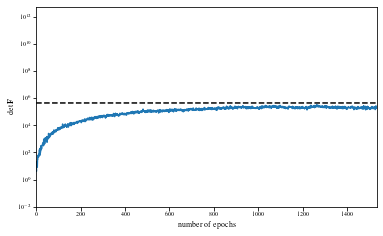

In [190]:
latexify(fig_width=5.37)
#plt.style.use('default')
plt.plot(IMNN.history['detF'][:])
plt.plot(np.ones(len(IMNN.history['detF'][:]))*detf_expected, c='k', linestyle='--')
plt.ylim(1e-2, 5e12)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN-training.png', dpi=400)

In [173]:
np.linalg.det(IMNN.F)

DeviceArray(259559.1, dtype=float32)

### using IMNN, create sampler that goes $f: \textbf{d} \mapsto \textbf{x}$
(outputs summaries via `get_estimate`)

In [135]:
@jit #partial(jax.jit, static_argnums=0)
def get_estimate(d):
    if len(d.shape) == 1:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)
    else:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)

def _f_NL_IMNN(
        α, β, 
        μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
            β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.expand_dims(α, (-1))),
                    tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
                    tfb.Exp(),
                    tfb.Shift(-np.float64(1.)),
                    tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1))),
                    get_estimate()])) ) )

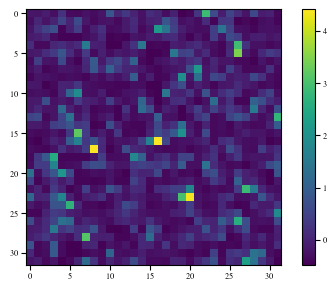

In [136]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))
target["f_NL"] = simulator(key, None, target["α"], target["β"])
plt.imshow(target["f_NL"].reshape((N, N)))
plt.colorbar()

In [142]:
target_data = np.expand_dims(np.expand_dims(target["f_NL"].reshape((N, N)), 0), 0)
estimates = get_estimate(target_data)

# prior

In [145]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)

prior = uniform([0., 0.2], [2., 0.8])

# ABC sampler

In [146]:
GAs = [GaussianApproximation(get_estimate(target_data), IMNN.invF, prior)]

In [ ]:
θ_fid

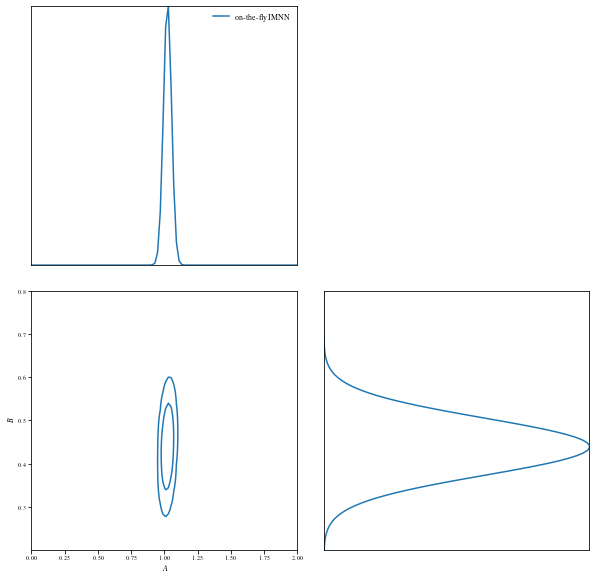

In [147]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

In [160]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : imnn_simulator(A,B, simulator_args={**simulator_args, **{'squeeze':True}}), 
                                       get_estimate, F=IMNN.F, gridsize=50
    )

In [161]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=20000,
        ϵ=0.05,
        smoothing=0.);

245 accepted in last  20000 iterations  (20000000 simulations done).
CPU times: user 1h 30min 38s, sys: 2.48 s, total: 1h 30min 40s
Wall time: 1h 30min 44s


(<imnn.utils.container.container at 0x154b884cd1c0>,
 <imnn.utils.container.container at 0x154b7e1948e0>)

In [167]:
ABC.parameters.accepted[0].shape

(245, 2)

In [168]:
np.save('accepted_ABC_LN', ABC.parameters.accepted[0])

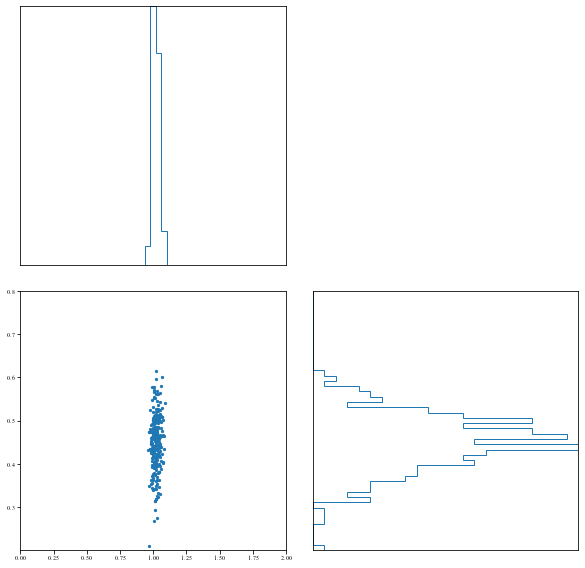

In [169]:
ax = ABC.scatter_plot()

In [188]:
# get comparison to true posterior
# prior = uniform([0., 0.2], [2., 0.8])
α_range = np.linspace(0., 2., num=300)
β_range = np.linspace(0.2, 0.8, num=300)

distr = _f_NL(α_range, β_range).prob(target)

In [189]:
distr

DeviceArray([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
              0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

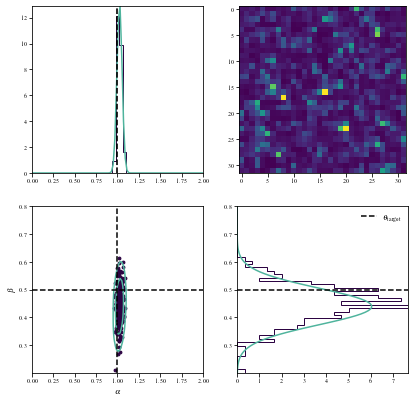

In [191]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$\alpha$", r"$\beta$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$\alpha$", r"$\beta$"], label=None, ncol=1)
ax[0,1].imshow(target_data[0, 0])

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(target['α'], linestyle='--', c='k')
ax[1,0].axvline(target['α'], linestyle='--', c='k')
ax[1,0].axhline(target['β'], linestyle='--', c='k')
ax[1,1].axhline(target['β'], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$\alpha$')
ax[1,0].set_ylabel(r'$\beta$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

#ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
#ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
# ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
# ax[0, 1].axis("off")
# ax[1, 0].contour(A_range, B_range, np.real(likelihood), levels=value, colors='#FF8D33')
# ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)

plt.savefig('/mnt/home/tmakinen/repositories/field-plots/LN-32x32-contours.png', dpi=400)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [195]:
num_burnin_steps = 100
num_results = int(1e3)
num_chains = 250

In [196]:
rng, α_key, β_key = jax.random.split(rng, num=3)
init_state = np.stack(
    [tfd.Uniform(low=np.float64(0.), high=np.float64(2.)).sample(num_chains, seed=α_key),
     tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)).sample(num_chains, seed=β_key)], 
    1)

In [197]:
@jax.jit
def run_mcmc(rng):
    def fn(init_state):
        return tfp.mcmc.sample_chain(
            num_results=num_results,
            current_state=tuple(init_state),
            kernel = tfp.mcmc.RandomWalkMetropolis(
                target_log_prob_fn=lambda α, β: _f_NL(α, β).log_prob(target)),
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=1,
            trace_fn=lambda _, stats: stats.accepted_results.target_log_prob,
            seed=rng)
    return jax.vmap(fn)(init_state)

In [198]:
@jax.jit
def run_mcmc_imnn(rng):
    def fn(init_state):
        return tfp.mcmc.sample_chain(
            num_results=num_results,
            current_state=tuple(init_state),
            kernel = tfp.mcmc.RandomWalkMetropolis(
                target_log_prob_fn=lambda α, β: _f_NL_IMNN(α, β).log_prob(target)),
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=1,
            trace_fn=lambda _, stats: stats.accepted_results.target_log_prob,
            seed=rng)
    return jax.vmap(fn)(init_state)

In [199]:
states = np.zeros((2, num_chains, 0))
stats = np.zeros((num_chains, 0))

In [200]:
rng, key = jax.random.split(rng)
_states, _stats = run_mcmc(key)
states = np.concatenate([states, np.stack(_states)], -1)
stats = np.concatenate([stats, _stats], -1)

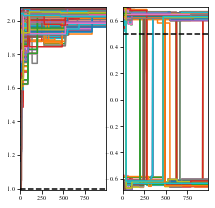

In [201]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(states[0].T)
ax[0].axhline(target["α"], linestyle="dashed", color="black")
ax[1].plot(states[1].T)
ax[1].axhline(target["β"], linestyle="dashed", color="black")

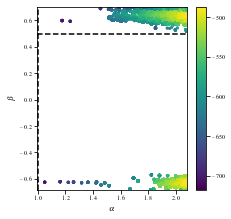

In [203]:
plt.scatter(states[0].flatten(), states[1].flatten(), c=stats.flatten(), s=5)
plt.axvline(target["α"], color="black", linestyle="dashed")
plt.axhline(target["β"], color="black", linestyle="dashed")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.colorbar()

In [29]:
states.shape

(2, 250, 1000)

In [29]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 6,
              'ytick.labelsize': 6,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()